In [12]:
import torch
from torch.utils.data import Dataset, DataLoader
import torch.optim as optim
from tqdm import tqdm
from heart_dataset import HeartDataset
from heart_model import VAE, loss_function, save_model, load_model
from heart_display import load_images
from heart_variables import output_path, model_path
from torchvision import transforms
from torchvision.transforms.functional import InterpolationMode
import torch.nn.functional as F
from heart_dice import compute_mean_dice
import itertools
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

import numpy as np

In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

### Preprocess pour pouvoir utiliser le modèle FID

In [3]:
def preprocess_2(images):
    preprocess = transforms.Compose([
        transforms.ToPILImage(),
        transforms.Resize((299, 299), interpolation=InterpolationMode.NEAREST),
        transforms.CenterCrop(299),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    ])
    images = torch.stack([preprocess(img) for img in images])
    return images

In [4]:
def preprocess_1(images):
    # Step 1: Compute the argmax along the channel dimension
    argmax_tensor = torch.argmax(images, dim=1)
    
    # Step 2: Subtract one from the argmax values
    subtracted_tensor = argmax_tensor - 1
    
    # Step 3: Apply ReLU to ensure values are within {0, 1, 2}
    relu_tensor = F.relu(subtracted_tensor)
    
    # Step 4: One-hot encode the resulting tensor into 3 channels
    one_hot_tensor = F.one_hot(relu_tensor, num_classes=3).permute(0,3,1,2).float()
    
    return one_hot_tensor

In [5]:
class ReconstructedDataset(Dataset):
    def __init__(self, reconstructed_images):
        self.reconstructed_images = reconstructed_images

    def __len__(self):
        return len(self.reconstructed_images)

    def __getitem__(self, idx):
        return self.reconstructed_images[idx]

In [6]:
def get_features(dataloader, model, device):
    model.eval()
    features = []

    with torch.no_grad():
        for batch in dataloader:
            batch = batch.to(device)
            batch = preprocess_1(batch).to(device)
            batch = preprocess_2(batch).to(device)
            output = model(batch)
            features.append(output.cpu().numpy())

    return np.concatenate(features, axis=0)

# Calculate statistics and FID score
def calculate_statistics(features):
    mu = np.mean(features, axis=0)
    sigma = np.cov(features, rowvar=False)
    return mu, sigma

def calculate_fid(mu1, sigma1, mu2, sigma2):
    from scipy.linalg import sqrtm
    diff = mu1 - mu2
    covmean, _ = sqrtm(sigma1.dot(sigma2), disp=False)
    if np.iscomplexobj(covmean):
        covmean = covmean.real
    return np.sum(diff**2) + np.trace(sigma1 + sigma2 - 2*covmean)

def get_fid_score(dataloader, fid_model, vae, batch_size, latent_dim, device):
    generated_images = []
    for batch in tqdm(dataloader, desc="Generating images"):
        with torch.no_grad():
            generated_latent = torch.randn(batch.shape[0], latent_dim).to(device)
            generated_batch = vae.decode(generated_latent)
            generated_images.append(generated_batch.cpu())

    # Flatten the list of generated images
    generated_images = torch.cat(generated_images, dim=0)

    # Create the generated dataset and dataloader
    generated_dataset = ReconstructedDataset(generated_images)
    dataloader_generated = DataLoader(generated_dataset, batch_size=batch_size, shuffle=False)

    # Extract features
    features_original = get_features(dataloader, fid_model, device)
    features_reconstructed = get_features(dataloader_generated, fid_model, device)

    # Calculate statistics
    mu1, sigma1 = calculate_statistics(features_original)
    mu2, sigma2 = calculate_statistics(features_reconstructed)

    # Calculate FID score
    fid_score = calculate_fid(mu1, sigma1, mu2, sigma2)  

    return fid_score  

In [7]:
images, names = load_images(output_path)
heart_dataset = HeartDataset(images)

### Modèle pour extraite les FID features

### Train du model, pas nécessaire tu peux juste load le modèle si tu veux 

In [ ]:
feature_extractor = torch.hub.load('pytorch/vision:v0.10.0', 'inception_v3', pretrained=True).to(device)
feature_extractor.eval()

# Define the hyperparameter grid
latent_dims = [4, 8, 12, 16, 32, 64]
batch_sizes = [8, 16, 32]
betas = [1.0, 10.0, 100.0, 500.0, 1000.0]

num_epochs = 50
learning_rate = 6e-5
l2_reg = 0.01

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

results = []

# Grid search over hyperparameters
for latent_dim, batch_size, beta in itertools.product(latent_dims, batch_sizes, betas):
    # Dataloader
    dataloader = DataLoader(heart_dataset, batch_size=batch_size, shuffle=True)

    # Model
    vae_model = VAE(latent_dim=latent_dim).to(device)
    optimizer = optim.AdamW(vae_model.parameters(), lr=learning_rate, weight_decay=l2_reg)

    # Training loop
    vae_model.train()
    print('latent_dim :', latent_dim, ' | batch_size :', batch_size, ' | beta :', beta)
    progress_bar = tqdm(total=num_epochs, desc=f'Training (latent_dim={latent_dim}, batch_size={batch_size}, beta={beta})', position=0)
    for epoch in range(num_epochs):
        train_loss = 0.0  # Reset the training loss for the next epoch
        progress_bar.set_description(f'Epoch {epoch+1}/{num_epochs}')
        for batch in dataloader:
            batch = batch.to(device)

            # Pass the input data through the model
            recon_batch, mu, logvar = vae_model(batch)
            # Compute the VAE loss
            loss = loss_function(recon_batch, batch, mu, logvar, beta)

            # Backpropagation
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            # Aggregate the training loss for display at the end of the epoch
            loss_item = loss.item()
            train_loss += loss_item
        
        progress_bar.set_postfix({'Loss': train_loss / len(dataloader)})
        progress_bar.update(1)

    progress_bar.close()

    # Evaluation
    dice = compute_mean_dice(vae_model, dataloader)
    fid = get_fid_score(dataloader, feature_extractor, vae_model, batch_size, latent_dim, device)

    print('dice :', dice, ' | fid :', fid)

    # Store the results
    results.append({
        'latent_dim': latent_dim,
        'batch_size': batch_size,
        'beta': beta,
        'dice': dice,
        'fid': fid
    })

# Print the results
for result in results:
    print(result)                                                                

In [16]:
# Find the best parameters for fid and dice
best_fid_params = min(results, key=lambda x: x['fid'])
best_dice_params = max(results, key=lambda x: x['dice'])

# Print the best results
print("Best parameters for FID:")
print(best_fid_params)

print("Best parameters for Dice:")
print(best_dice_params)

Best parameters for FID:
{'latent_dim': 12, 'batch_size': 16, 'beta': 500.0, 'dice': 0.8463644866182023, 'fid': 114.31707569470481}
Best parameters for Dice:
{'latent_dim': 64, 'batch_size': 8, 'beta': 1.0, 'dice': 0.9202481270337305, 'fid': 547.161119546789}


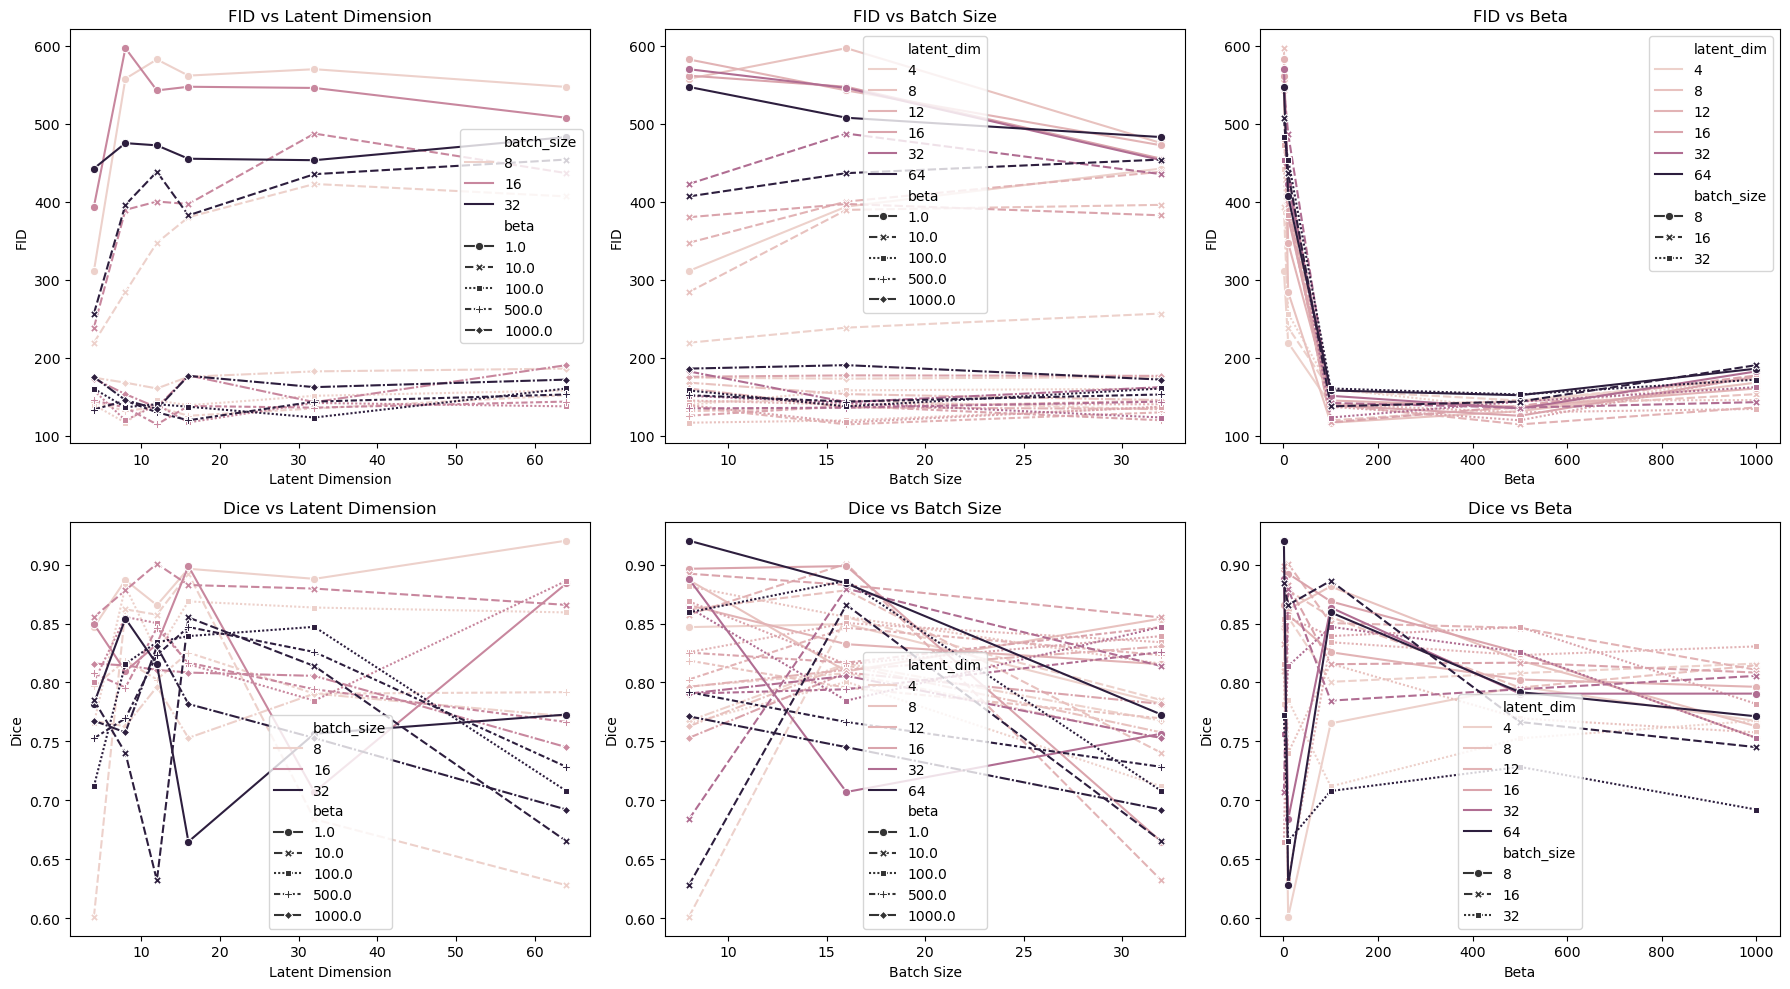

In [18]:
# Convert results to a DataFrame
results_df = pd.DataFrame(results)

# Plotting
fig, axes = plt.subplots(2, 3, figsize=(18, 10))

# FID vs Latent Dimension
sns.lineplot(ax=axes[0, 0], data=results_df, x='latent_dim', y='fid', hue='batch_size', style='beta', markers=True)
axes[0, 0].set_title('FID vs Latent Dimension')
axes[0, 0].set_xlabel('Latent Dimension')
axes[0, 0].set_ylabel('FID')

# FID vs Batch Size
sns.lineplot(ax=axes[0, 1], data=results_df, x='batch_size', y='fid', hue='latent_dim', style='beta', markers=True)
axes[0, 1].set_title('FID vs Batch Size')
axes[0, 1].set_xlabel('Batch Size')
axes[0, 1].set_ylabel('FID')

# FID vs Beta
sns.lineplot(ax=axes[0, 2], data=results_df, x='beta', y='fid', hue='latent_dim', style='batch_size', markers=True)
axes[0, 2].set_title('FID vs Beta')
axes[0, 2].set_xlabel('Beta')
axes[0, 2].set_ylabel('FID')

# Dice vs Latent Dimension
sns.lineplot(ax=axes[1, 0], data=results_df, x='latent_dim', y='dice', hue='batch_size', style='beta', markers=True)
axes[1, 0].set_title('Dice vs Latent Dimension')
axes[1, 0].set_xlabel('Latent Dimension')
axes[1, 0].set_ylabel('Dice')

# Dice vs Batch Size
sns.lineplot(ax=axes[1, 1], data=results_df, x='batch_size', y='dice', hue='latent_dim', style='beta', markers=True)
axes[1, 1].set_title('Dice vs Batch Size')
axes[1, 1].set_xlabel('Batch Size')
axes[1, 1].set_ylabel('Dice')

# Dice vs Beta
sns.lineplot(ax=axes[1, 2], data=results_df, x='beta', y='dice', hue='latent_dim', style='batch_size', markers=True)
axes[1, 2].set_title('Dice vs Beta')
axes[1, 2].set_xlabel('Beta')
axes[1, 2].set_ylabel('Dice')

plt.tight_layout()
plt.show()

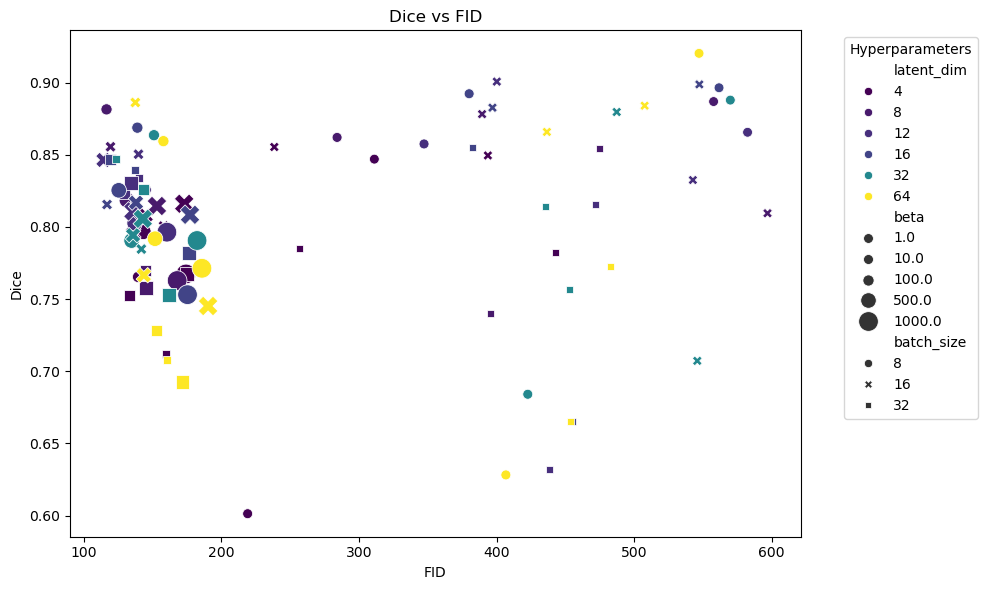

In [19]:
# Plotting Dice vs FID
plt.figure(figsize=(10, 6))
sns.scatterplot(data=results_df, x='fid', y='dice', hue='latent_dim', style='batch_size', size='beta', markers=True, palette='viridis', sizes=(50, 200))

plt.title('Dice vs FID')
plt.xlabel('FID')
plt.ylabel('Dice')
plt.legend(title='Hyperparameters', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()